In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')
import segmentation_models as sm


Tensorflow ver. 2.12.0
Segmentation Models: using `keras` framework.


In [ ]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = '/content/drive/MyDrive/ee8208project/idd20k_lite/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
# Reference -> https://docs.python.org/2/library/glob.html
# The glob module finds all the pathnames matching a specified pattern according to
# the rules used by the Unix shell, although results are returned in arbitrary order.

TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1403 images.
The Validation Dataset contains 204 images.


In [ ]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=1)
    # In scene parsing, "not labeled"  = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/image/resize
# Resize images to the size specified

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


In [ ]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
# Getting a sample image for visualizing
i=1
for image, mask in dataset['train'].take(i):
    sample_image, sample_mask = image, mask

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[31], sample_mask[31]])

print(np.unique(sample_mask[31]))

In [ ]:
x_train=[]
x_mask=[]

for i in range(44):
  for image, mask in dataset['train'].take(i):
      sample_image, sample_mask = image, mask
  for j in range(len(sample_image)):
    x_train.append(sample_image[j])
    x_mask.append(sample_mask[j])



In [ ]:
x_val=[]
mask_val=[]

for i in range(44):
  for image, mask in dataset['val'].take(i):
      sample_image, sample_mask = image, mask
  for j in range(len(sample_image)):
    x_val.append(sample_image[j])
    mask_val.append(sample_mask[j])


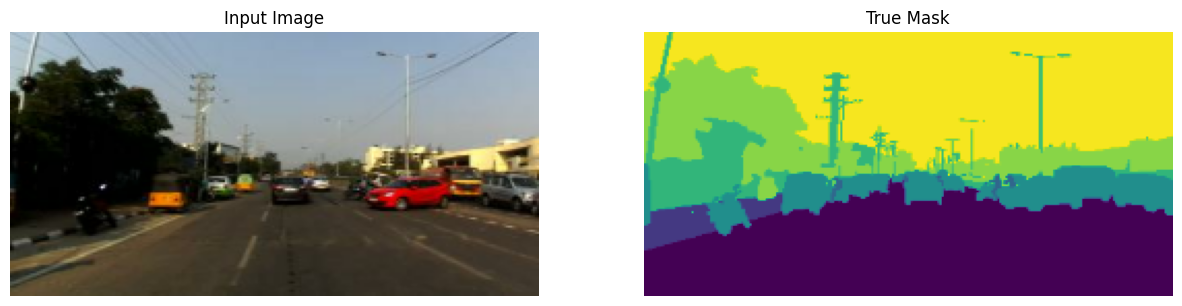

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[31], sample_mask[31]])

In [ ]:
x_train = np.array(x_train)
print(x_train[31].shape)


(128, 256, 3)


In [ ]:
print(x_train.shape)

(1408, 128, 256, 3)


In [ ]:
x_mask = np.array(x_mask)
print(x_mask.shape)

(1408, 128, 256, 1)


In [ ]:
x_val=np.array(x_val)
print(x_val.shape)

(1408, 128, 256, 3)


In [ ]:
mask_val=np.array(mask_val)
print(mask_val.shape)

(1408, 128, 256, 1)


In [ ]:
from keras.utils import to_categorical
y_train_temp= to_categorical(x_mask, num_classes=N_CLASSES)
y_train = y_train_temp.reshape((y_train_temp.shape[0], y_train_temp.shape[1], y_train_temp.shape[2], N_CLASSES))

print(y_train.shape)


(1408, 128, 256, 8)


In [ ]:
from keras.utils import to_categorical
y_val_temp= to_categorical(mask_val, num_classes=N_CLASSES)
y_val = y_val_temp.reshape((y_val_temp.shape[0], y_val_temp.shape[1], y_val_temp.shape[2], N_CLASSES))

print(y_val.shape)

(1408, 128, 256, 8)


In [ ]:
!pip install -U segmentation-models

  Attempting uninstall: image-classifiers
    Found existing installation: image-classifiers 0.2.0
    Uninstalling image-classifiers-0.2.0:
      Successfully uninstalled image-classifiers-0.2.0
  Attempting uninstall: segmentation-models
    Found existing installation: segmentation-models 0.2.1
    Uninstalling segmentation-models-0.2.1:
      Successfully uninstalled segmentation-models-0.2.1


AttributeError: ignored

In [ ]:
#now that data is gucci, lets try the resnet thing

activation_function='softmax'
#define the learning rat, which is usually by defualt 0.0001
LR=0.0001
#define the optimizer
optimizer=keras.optimizers.Adam(LR)

#defining the losses

total_loss sm.losses.binary_focal_dice_loss + or sm.losses.categorical_focal_dice_loss

#below is the metrics your tracking
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

##########################################################
# Model 1 -- try using resnet

backbone1='resnet34'

# for each of the backbones, you need to process the data in a certain why and the segmentation models library provides that
preprocess_backbone1=sm.get_preprocessing(backbone1)
x_trains1=preprocess_backbone1(x_train)
x_val1=preprocess_backbone1(x_val)

# define model
# the encoder weights basically lets you have a starting points for the weights so there not random
# this way we dont start at random weights, the model was trained on imagenet so there is a good starting point
resnet34_backbone= sm.Unet(backbone1, encoder_weights='imagenet', classes=N_CLASSES, activation=activation_function)

# compile keras model with defined optimozer, loss and metrics
resnet34_backbone.compile(optimizer, total_loss, metrics=metrics)
print(resnet34_backbone.summary())

history1=resnet34_backbone.fit(x_trains1,y_train_cat,batch_size=32,epochs=100,verbose=1,validation_data=(x_val, y_val))
resnet34_backbone.save('res34sample_100epochs_32batch.hdf5')
